In [31]:
from pm4py.visualization.dfg import visualizer as dfg_visualizer

# (auto-reload changes from imported libraries)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import ast 
from cmp_logs_v2 import compare_nodes_edges_dfg, GroupTypes, print_compare_results

def read_dict(path):
    with open(path) as file:
        data = file.read()
    return ast.literal_eval(data)

def compare_by_log(dfgs, labels):
    # construct DFG for each sublog & get comparison results
    cmp_results = compare_nodes_edges_dfg(dfgs)

    # print the comparison results in a "human-readable" format
    print("-- compare by log\n")
    print_compare_results(cmp_results, labels, group_type=GroupTypes.BY_LOG)

# Compare Two Mined Processes

{('In Progress - Assessor Reviewing', 'In Progress - Assigned'): 1, ('In Progress - Assigned', 'Completed - Assessment Complete'): 1, ('In Progress - Letter - Defer', 'New - Received'): 1, ('In Progress - Letter - Defer', 'On Hold (Pending) - Await Applicant'): 1, ('Medical Exam Date', 'New - Create File'): 47, ('Medical Exam Date', 'New - Received'): 3, ('Medical Exam Date', 'Received Date'): 37, ('New - Create File', 'New - Received'): 83, ('New - For AMO/RAMO', 'Completed - Assessment Complete'): 1, ('New - Received', 'Completed - Assessment Complete'): 84, ('New - Received', 'In Progress - Assessor Reviewing'): 1, ('New - Received', 'In Progress - Letter - Defer'): 2, ('New - Received', 'New - For AMO/RAMO'): 1, ('Received Date', 'Medical Exam Date'): 50, ('Received Date', 'New - Create File'): 36, ('Received Date', 'New - Received'): 1}


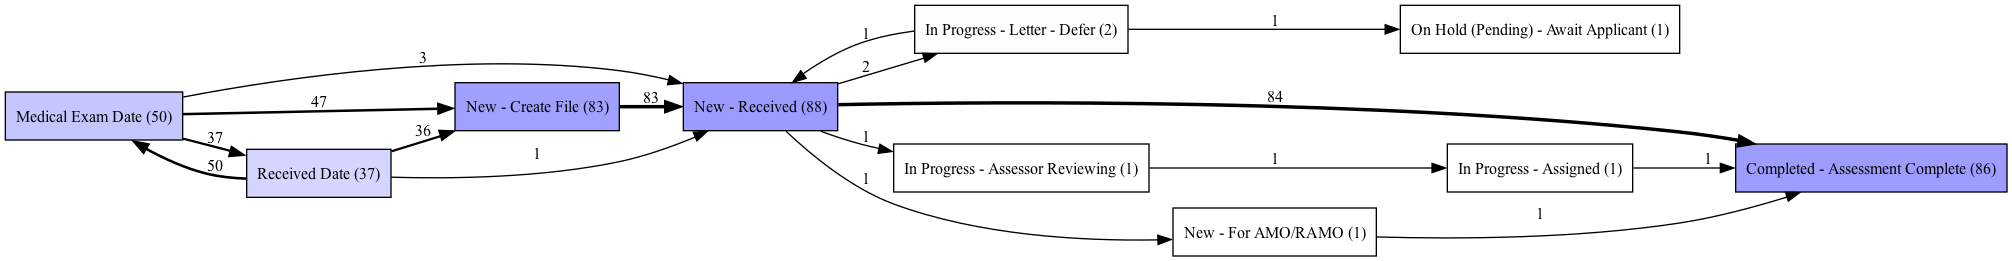

In [33]:
dfg1 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New1_Event Dictionary.py')
print(dfg1)
dfg_visualizer.view(dfg_visualizer.apply(dfg1))

{('Completed - Assessment Complete', 'In Progress - Letter - Defer'): 1, ('Completed - Assessment Complete', 'In Progress - Letter - Fit'): 1, ('In Progress - Assessor Reviewing', 'Completed - Assessment Complete'): 3, ('In Progress - Assessor Reviewing', 'On Hold (Pending) - Await Applicant'): 2, ('In Progress - Assigned', 'For AMO/RAMO'): 1, ('In Progress - For Follow-up Review', 'Completed - Assessment Complete'): 2, ('In Progress - For Follow-up Review', 'In Progress - Letter - Defer'): 1, ('In Progress - Letter - Defer', 'Completed - Assessment Complete'): 2, ('In Progress - Letter - Defer', 'On Hold (Pending) - Await Applicant'): 24, ('In Progress - Letter - Fit', 'Completed - Assessment Complete'): 3, ('In Progress - Letter - Fit', 'On Hold (Pending) - Await Applicant'): 1, ('Medical Exam Date', 'Create File'): 188, ('Medical Exam Date', 'Received'): 4, ('Create File', 'Received'): 416, ('For AMO/RAMO', 'Completed - Assessment Complete'): 71, ('For AMO/RAMO', 'In Progress - Asse

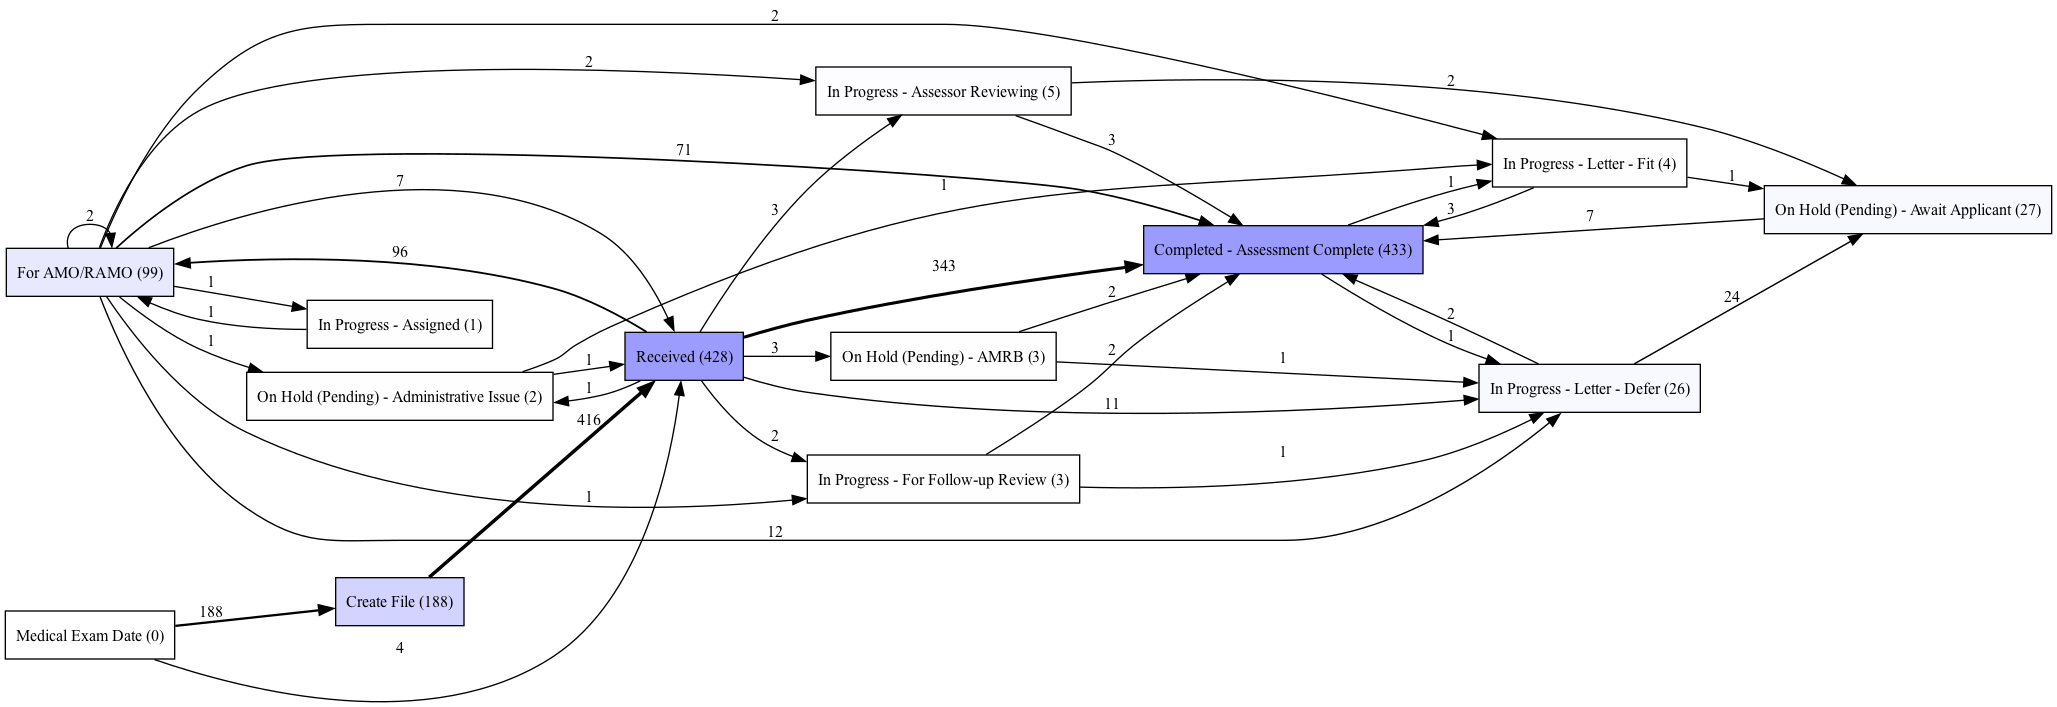

In [48]:
dfg2 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New2_Event Dictionary.py')
print(dfg2)
dfg_visualizer.view(dfg_visualizer.apply(dfg2))

In [35]:
compare_by_log([ dfg1, dfg2 ], [ 'New for Period I', 'New for Period II' ])

-- compare by log

> log New for Period I
- compared to log New for Period II:
. extra events: new - create file, new - received, new - for amo/ramo
. missing events: for amo/ramo, on hold (pending) - amrb, in progress - letter - fit, received, in progress - for follow-up review, create file, on hold (pending) - administrative issue
. extra edges:
 in progress - assessor reviewing -> in progress - assigned
in progress - assigned -> completed - assessment complete
in progress - letter - defer -> new - received
medical exam date -> new - create file
medical exam date -> new - received
new - create file -> new - received
new - for amo/ramo -> completed - assessment complete
new - received -> completed - assessment complete
new - received -> in progress - assessor reviewing
new - received -> in progress - letter - defer
new - received -> new - for amo/ramo
received date -> new - create file
received date -> new - received
. missing edges:
 completed - assessment complete -> in progress - l

# Compare Mined With Normative Process

In [49]:
dfg2 = read_dict('./data/Event Dictionaries/PMed_Reallocation_New2_Event Dictionary.py')
norm = read_dict("./data/tc_medical_cert-normative-align.py")

norm_dict = {}
for src, tgt in norm:
    norm_dict[src.lower()] = True
    norm_dict[tgt.lower()] = True
print(norm_dict)

for src, tgt in dfg2:
    src = src.lower()
    tgt = tgt.lower()
    if src not in norm_dict:
        print("not found:", src)
    if tgt not in norm_dict:
        print("not found:", tgt)

{'medical exam date': True, 'create file': True, 'received': True, 'renewed by came': True, 'end': True, 'in progress - letter - unfit': True, 'completed - assessment complete': True, 'in progress - letter - defer': True, 'on hold (pending) - await applicant': True, 'in progress - letter - fit': True, 'for amo/ramo': True, 'on hold (pending) - amrb': True, 'duplicate': True, 'created in error': True, 'file retrieval': True, 'file retrieved': True, 'on hold (pending) - administrative issue': True, 'withdrawn by applicant': True, 'request additional docs?': True, 'in progress - for follow-up review': True, 'request additional tests?': True, 'additional test results received? or            for followup review? ': True, 'in progress - assessor reviewing': True, 'triage': True, 'update file?': True}
not found: in progress - assigned
not found: in progress - assigned


{('Medical Exam Date', 'Create File'): 1, ('Create File', 'Received'): 1, ('Received', 'Renewed by CAME'): 1, ('Renewed by CAME', 'End'): 1, ('Renewed by CAME', 'In Progress - Letter - Unfit'): 1, ('In Progress - Letter - Unfit', 'Completed - Assessment Complete'): 1, ('Completed - Assessment Complete', 'End'): 1, ('Renewed by CAME', 'In Progress - Letter - Defer'): 1, ('In Progress - Letter - Defer', 'On Hold (Pending) - Await applicant'): 1, ('On Hold (Pending) - Await applicant', 'End'): 1, ('Renewed by CAME', 'In Progress - Letter - Fit'): 1, ('In Progress - Letter - Fit', 'Completed - Assessment Complete'): 1, ('Received', 'For AMO/RAMO'): 1, ('For AMO/RAMO', 'On Hold (Pending) - AMRB'): 1, ('For AMO/RAMO', 'Duplicate'): 1, ('Duplicate', 'End'): 1, ('For AMO/RAMO', 'Created in error'): 1, ('Created in error', 'End'): 1, ('For AMO/RAMO', 'File retrieval'): 1, ('File retrieval', 'File retrieved'): 1, ('File retrieved', 'On Hold (Pending) - AMRB'): 1, ('File retrieved', 'Duplicate'):

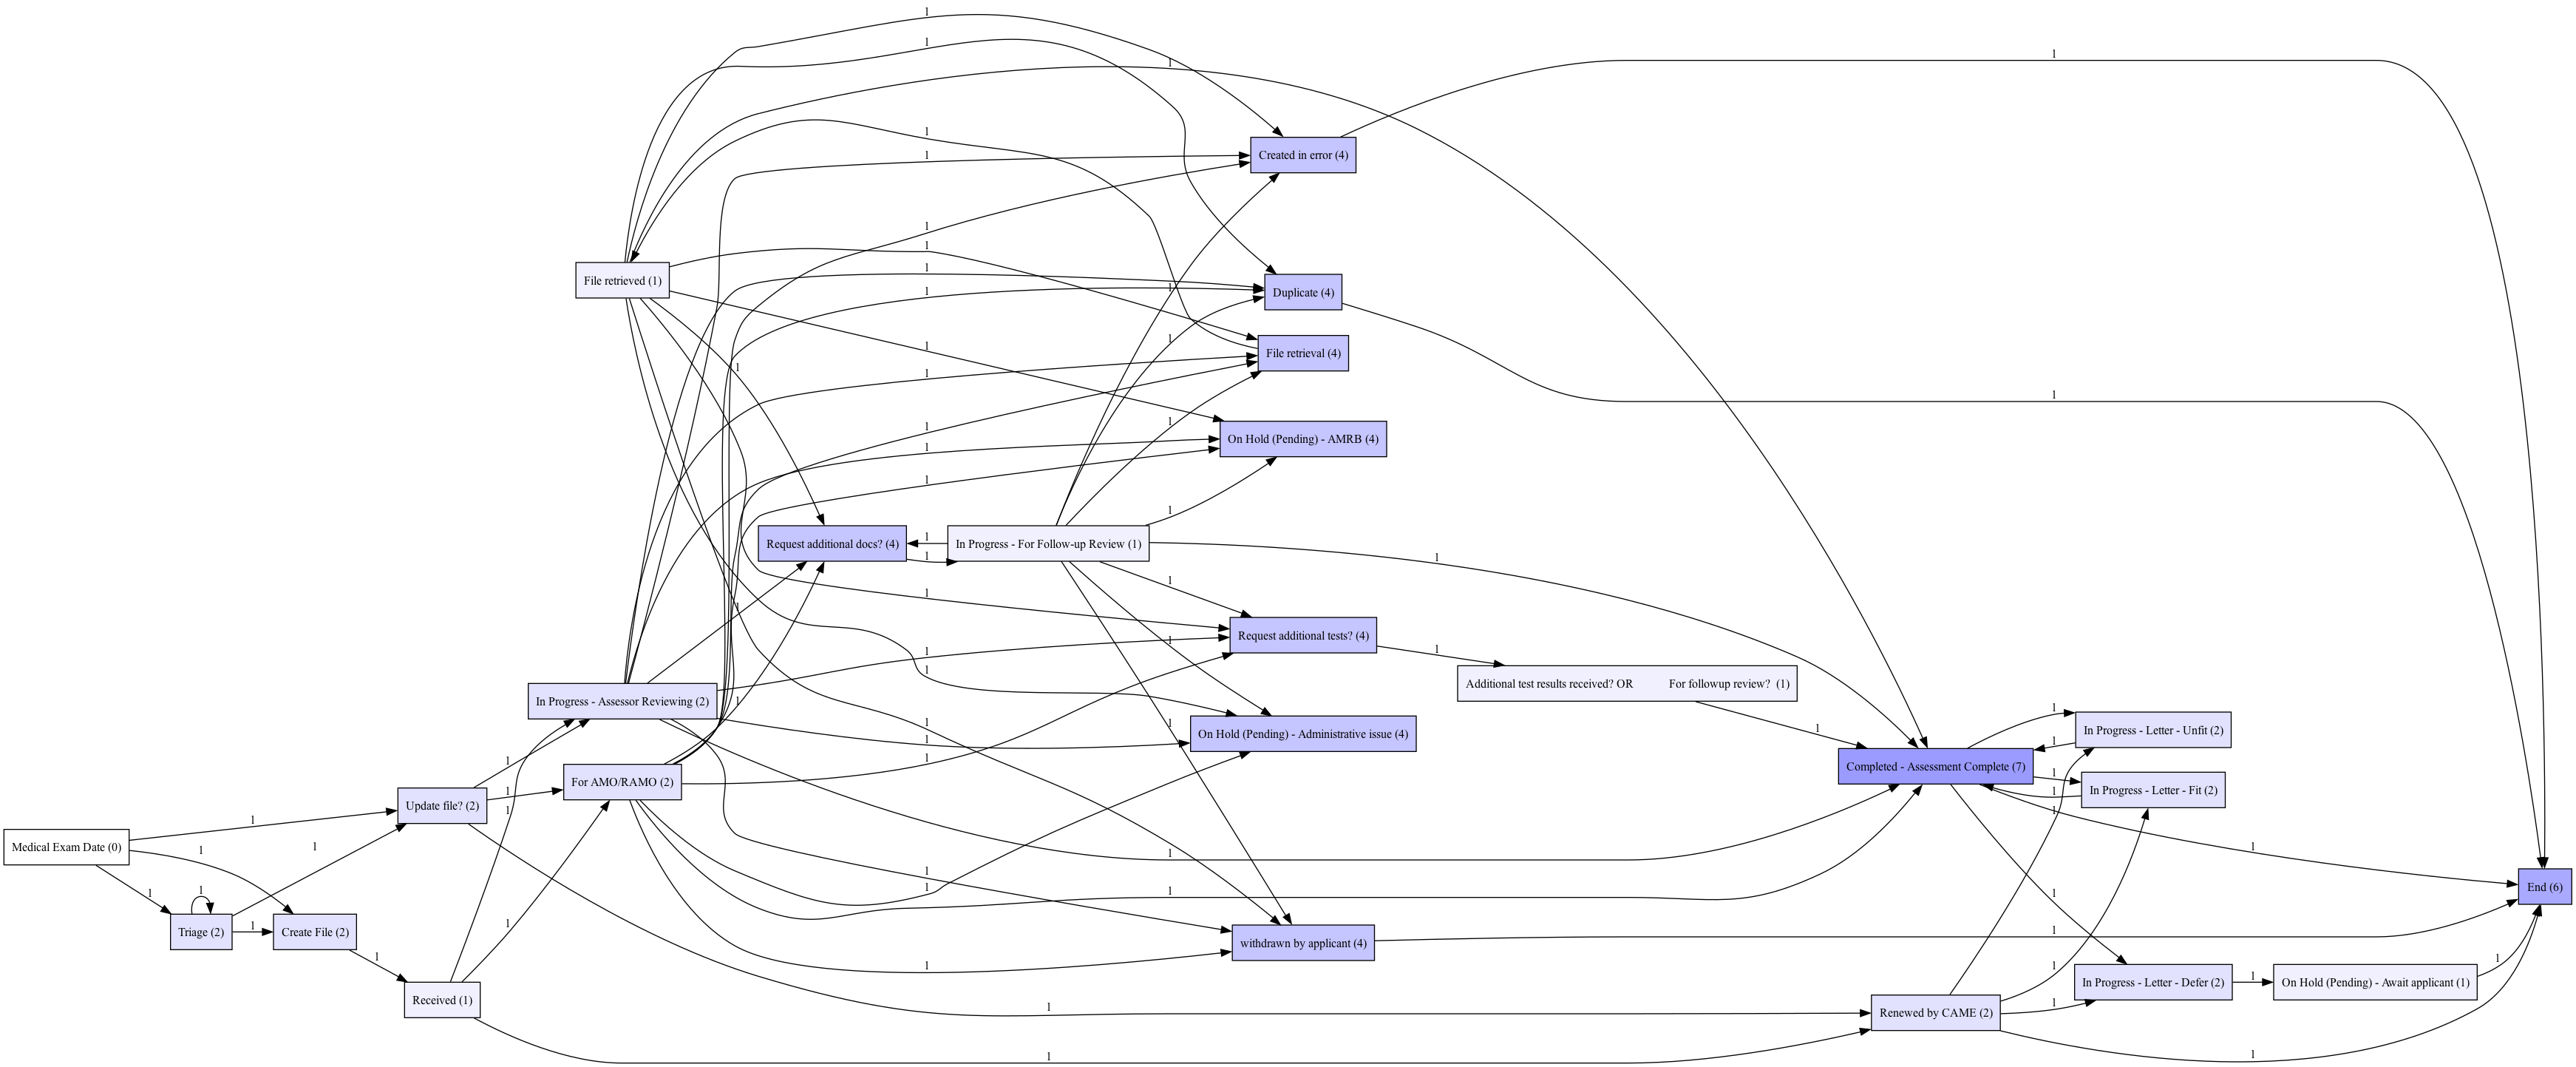

In [45]:
print(norm)
dfg_visualizer.view(dfg_visualizer.apply(norm))

In [50]:
compare_by_log([ dfg2, norm ], [ 'New for Period II', 'Normative' ])

-- compare by log

> log New for Period II
- compared to log Normative:
. extra events: in progress - assigned
. missing events: file retrieved, withdrawn by applicant, request additional docs?, request additional tests?, duplicate, created in error, update file?, additional test results received? or            for followup review? , in progress - letter - unfit, triage, file retrieval, end, renewed by came
. extra edges:
 in progress - assessor reviewing -> on hold (pending) - await applicant
in progress - assigned -> for amo/ramo
in progress - for follow-up review -> in progress - letter - defer
in progress - letter - defer -> completed - assessment complete
in progress - letter - fit -> on hold (pending) - await applicant
medical exam date -> received
for amo/ramo -> in progress - assessor reviewing
for amo/ramo -> in progress - assigned
for amo/ramo -> in progress - for follow-up review
for amo/ramo -> in progress - letter - defer
for amo/ramo -> in progress - letter - fit
for amo/